In [108]:
import cv2
#https://github.com/experiencor/keras-yolo3
from pydarknet import Detector, Image
import cv2
import os
import pickle
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.models import load_model
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.3.1


# The followings are keras YOLOv3 to generate bounding boxes.

In [109]:
model = load_model('model.h5')

In [110]:
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
                    
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

In [169]:
def load_image_pixels(filename, shape):
        # load the image to get its shape
        image = load_img(filename)
        width, height = image.size
        # load the image with the required size
        image = load_img(filename, target_size=shape)
        # convert to numpy array
        image = img_to_array(image)
        # scale pixel values to [0, 1]
        image = image.astype('float32')
        image /= 255.0
        # add a dimension so that we have one sample
        image = expand_dims(image, 0)
        return image, width, height

# Specify the image file name

In [170]:
input_w, input_h = 416, 416
photo_filename = 'data/0000000008.png'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
## make prediction
yhat = model.predict(image)
print(yhat)
## summarize the shape of the list of arrays


[array([[[[ 3.1483549e-01, -5.6140625e-01, -7.2292462e-03, ...,
          -6.4780889e+00, -7.1281610e+00, -7.2282023e+00],
         [ 1.3833892e+00,  4.8428413e-01,  3.4694752e-01, ...,
          -7.8857341e+00, -9.2962961e+00, -9.9903393e+00],
         [-8.6652285e-01,  1.2658137e+00,  4.9687028e-01, ...,
          -9.2903585e+00, -9.6623936e+00, -9.5359888e+00],
         ...,
         [-2.8680064e-02,  6.6749620e-01,  1.7130002e-03, ...,
          -7.1327329e+00, -7.6608038e+00, -6.8036036e+00],
         [-5.4101235e-01,  3.1515467e-01,  5.8983378e-02, ...,
          -4.9013019e+00, -6.1442766e+00, -5.5386705e+00],
         [-5.6889242e-01,  3.8234991e-01,  3.4690347e-01, ...,
          -3.0712163e+00, -4.6771140e+00, -4.0793195e+00]],

        [[ 1.2152603e+00,  3.2716194e-01, -2.9837963e-01, ...,
          -6.7530012e+00, -7.4857559e+00, -8.0481071e+00],
         [ 3.1157717e-02,  7.2291243e-01, -1.7538714e-01, ...,
          -9.5341568e+00, -1.0280754e+01, -1.1471586e+01],
       

In [171]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()

input_w, input_h = 416, 416
image_w = 416
image_h = 416

for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image

correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
        "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
        "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
        "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
        "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
        "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
        "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
        "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
        "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

data_stats_dict = {}

# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
    
    if v_labels[i] not in data_stats_dict.keys():
        data_stats_dict[v_labels[i]] =[v_scores[i]]
    else:
        data_stats_dict[v_labels[i]].append(v_scores[i])
        
for i in range(len(v_boxes)):
    box = v_boxes[i]
    # get coordinates
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    # calculate width and height of the box
    #width, height = x2 - x1, y2 - y1
    #rgb_values = image[x1:x2, y1:y2]   
    print(v_labels[i], ",", v_scores[i],",","upper left coor=", x1,y1, "lower right coor = ",x2,y2,)
    

person 99.52588677406311
person 99.72745180130005
person 98.58593344688416
backpack 77.26823091506958
fire hydrant 60.49702167510986
person , 99.52588677406311 , upper left coor= 84 212 lower right coor =  115 282
person , 99.72745180130005 , upper left coor= 142 208 lower right coor =  165 285
person , 98.58593344688416 , upper left coor= 189 209 lower right coor =  216 297
backpack , 77.26823091506958 , upper left coor= 94 220 lower right coor =  109 242
fire hydrant , 60.49702167510986 , upper left coor= 350 223 lower right coor =  358 239


In [172]:
data_stats_dict = {}

# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
    
    if v_labels[i] not in data_stats_dict.keys():
        data_stats_dict[v_labels[i]] =[v_scores[i]]
    else:
        data_stats_dict[v_labels[i]].append(v_scores[i])
data_stats_dict

person 99.52588677406311
person 99.72745180130005
person 98.58593344688416
backpack 77.26823091506958
fire hydrant 60.49702167510986


{'person': [99.52588677406311, 99.72745180130005, 98.58593344688416],
 'backpack': [77.26823091506958],
 'fire hydrant': [60.49702167510986]}

Consider ALL the boundingbox by Yolo for the same type of labeled objects

In [173]:
#a dictionary to select one type of labeled objects per frame
# the key is the label, the value is the probability, with coordinates
# sorted by highest probability to lowest
sorted_vboxes={}

for i in range(len(v_boxes)):
    box = v_boxes[i]
    # get coordinates
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    # calculate width and height of the box
    #width, height = x2 - x1, y2 - y1
    #rgb_values = image[x1:x2, y1:y2]   
    #print(v_labels[i], ",", v_scores[i],",","upper left coor=", x1,y1, "lower right coor = ",x2,y2,)
    
    if v_labels[i] not in sorted_vboxes.keys():
        #print("put into dict")
        sorted_vboxes[v_labels[i]] = [tuple((x1,y1,x2,y2))]
    else:
        sorted_vboxes[v_labels[i]].append((x1,y1,x2,y2))

# YOLOV3 labeled objects, with probabilities and coordinates.
We consider ALL object of the same type, regardless of the prediction probabilities.

In [174]:
#This is the dictionary containing labels from kera Yolov3, with all the coordinates of all labeled bbox.
sorted_vboxes

{'person': [(84, 212, 115, 282), (142, 208, 165, 285), (189, 209, 216, 297)],
 'backpack': [(94, 220, 109, 242)],
 'fire hydrant': [(350, 223, 358, 239)]}

# The followings are functions to calculate overlapping pixels.

In [175]:
#consider the gap to the center=5, can be adjusted
def func_dist_to_centre_boundingbox(lime_x, lime_y,ymin, xmin, ymax, xmax, gap):
    centre_of_bounding_box_x = xmin + (xmax-xmin)/2
    centre_of_bounding_box_y = ymin + (ymax-ymin)/2
    if abs(lime_x - centre_of_bounding_box_x) <= gap and abs(lime_y - centre_of_bounding_box_y) <= gap:
        return True
    else:
        return False


In [176]:
def func_check_on_the_border(lime_x, lime_y,ymin, xmin, ymax, xmax, gap):
    if (abs(lime_x - xmin)<=gap and abs(lime_y -ymin) <= gap) or (abs(lime_x - xmin)<= gap and abs(lime_y -ymax) <= gap) or (abs(lime_x - xmax)<=gap and abs(lime_y -ymin) <= gap) or (abs(lime_x - xmax)<= gap and abs(lime_y -ymax) <= gap):
        return True
    else:
        return False


In [177]:
def func_check_within_box(lime_x, lime_y,ymin, xmin, ymax, xmax):
    if (lime_x >= xmin) and (lime_x <= xmax) and (lime_y >= ymin) and (lime_y <= ymax):
        return True
    else:
        return False


In [178]:
def func_3list_count_intersect(list_pixels_Lime, box_ymin, box_xmin, box_ymax, box_xmax, gap):
    y1, x1, y2, x2 = box_ymin, box_xmin, box_ymax, box_xmax
    obj_list_pixels_Lime = list_pixels_Lime
    #check for each pixels from Lime
    list_pixel_on_centre=[]
    list_pixel_on_border = []
    list_pixel_inside_box = []
        
    for each in range(len(obj_list_pixels_Lime)):
        superpixel_lst = obj_list_pixels_Lime[each]
        #print("length of current superpixel is ", len(superpixel_lst))
                  
        for j in range(len(superpixel_lst)):
        #Jiye: Note that  the coordinates are all reversed from superpixel
            Lime_y = float(superpixel_lst[j][0])
            Lime_x = float(superpixel_lst[j][1])
            #print(Lime_x, Lime_y, y1, x1, y2, x2)
            
            if func_dist_to_centre_boundingbox(Lime_x, Lime_y,y1, x1, y2, x2, 5):
                #print("find centre")
                list_pixel_on_centre.append(superpixel_lst[j])
            if func_check_on_the_border(Lime_x, Lime_y,y1, x1, y2, x2, 5):
                #print("find border")
                list_pixel_on_border.append(superpixel_lst[j])
            if func_check_within_box(Lime_x, Lime_y, y1, x1, y2, x2):
                #print("find inside")
                list_pixel_inside_box.append(superpixel_lst[j])

        print("total pixels inside superpixels = ", len(superpixel_lst), len(list_pixel_on_centre), len(list_pixel_on_border), len(list_pixel_inside_box))

    return (len(superpixel_lst), len(list_pixel_on_centre), len(list_pixel_on_border), len(list_pixel_inside_box))
    

In [179]:
#Function for overlapping the lime superpixel on the boundingbox by Yolo
#Input is the dictionary, with label and tuple(probability, coordinates) from boundingbox by Yolo
#### multiple tuples of bbox #####
#
# Note that we consider multiple labels per type, i.e, one car, one traffic light...
#Input 2nd, is the dictionary of all the labeled objects from Lime with its superpixel coordinates
# output is the list of overlapping pixel counts

def func_get_coordinates(tuple_coordinates):
    x1 = tuple_coordinates[0]
    y1 = tuple_coordinates[1]
    x2 = tuple_coordinates[2]
    y2 = tuple_coordinates[3]
    
    return (x1, y1, x2, y2)
    
def func_overlapping_superpixel_vs_boundingbox(v_boxes, dict_superpixel_coor, gap):
    
    dict_mult_object_overlapping_ct = {} #dictionary for multiple objects of the same label
    dict_overlapping_count = {}
    
    #for i in range(len(v_boxes)):
    for key in v_boxes.keys():
        label = key
        
        dict_overlapping_count[label] = {}
        
        
        #box = v_boxes[i] #label
        # get coordinates
        
        ct_total = 0
        ct_centre = 0
        ct_border = 0
        ct_inside = 0
        
        for j in range(len(v_boxes[label])-1): # v_boxes[key] is a list of coordinates for multiple bbox
                                            # last item in this list is the label from Lime
            if type(v_boxes[label][j]) != int:
                print("j = ", j, v_boxes[label][j])    
                x1,y1,x2,y2 = func_get_coordinates(v_boxes[label][j])
           
                lime_id = v_boxes[label][-1]
                #y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax 
                print(label, ",", "upper left coor=", x1,y1, "lower right coor = ",x2,y2,)

                #the following is a dictionary of key=superpixel_id, value=pixels_coordinates
                dict_pixels_from_superpixels_obj = dict_superpixel_coor[lime_id]
            
        
                
                for key in dict_pixels_from_superpixels_obj.keys():
                    print("The superpixel = ", key)
                    car_list_pixels_Lime = []
                    car_list_pixels_Lime.append(dict_pixels_from_superpixels_obj[key])
                    #print("car_list_pixels_Lime", car_list_pixels_Lime)
                    ct_total_one, ct_centre_one, ct_border_one, ct_inside_one = func_3list_count_intersect(car_list_pixels_Lime,  y1, x1, y2, x2, gap)
                    dict_overlapping_count[label][key]=([ct_total_one, ct_centre_one, ct_border_one, ct_inside_one])
                    ct_total = ct_total + ct_total_one
                    ct_centre = ct_centre + ct_centre_one
                    ct_border = ct_border + ct_border_one
                    ct_inside = ct_inside + ct_inside_one
                
        dict_mult_object_overlapping_ct[label]=[ct_total, ct_centre, ct_border, ct_inside]
        
            
    return (dict_mult_object_overlapping_ct)


# We use Lime image explainer to generate most positive superpixels. 
Note that generating the explanation takes more than one hour. The explanation is pre-generated, and is loaded from the pickle file.

In [180]:
# The followings are from Lime.
#image_to_explain, and explanation
image_to_explain = load_image_pixels(photo_filename, (416,416))[0][0]

explanation = pickle.load(open("explain_image_0000000008_add_backpack.pickle","rb"))
#photo_filename = 'data/2019_02_27_0022_0000000027.png'
lime_label_list = explanation.top_labels
for i in range(len(lime_label_list)):
    ID = lime_label_list[i] 
    lime_label_list[i] = tuple((lime_label_list[i],labels[ID]))
# Jiye: [7, 2, 5, 9, 0]
# [truck, car, bus, traffic_light , person]
#Jiye: create a list of tuples of (label_ID, string)
lime_label_list

[(0, 'person'),
 (10, 'fire hydrant'),
 (2, 'car'),
 (11, 'stop sign'),
 (7, 'truck')]

In [181]:
#explanation = pickle.load(open("explain_image_0000000008.pickle","rb"))
explanation = pickle.load(open("explain_image_0000000008_add_backpack.pickle","rb"))
explanation.top_labels

[0, 10, 2, 11, 7]

Play with the top_labels[n] n=0,1,2,3,4 to see the green and red superpixels.

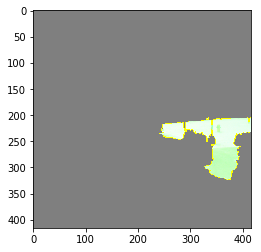

In [182]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

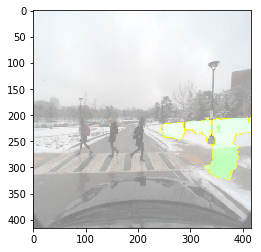

In [210]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [211]:
#This is the dictionary containing labels from kera Yolov3, with all the coordinates of all labeled bbox.
sorted_vboxes

{'person': [(84, 212, 115, 282),
  (142, 208, 165, 285),
  (189, 209, 216, 297),
  0],
 'fire hydrant': [(350, 223, 358, 239), 1]}

In [184]:
#for each labeled objects from Yolo, search for the corresponding green superpixels by Lime.
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
            "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "backpack"]

ignore_key = []
lime_position_list = []
lime_position_label_pair_list = [] #used only to calculate img_descriptor overlapping with bbox
for key in sorted_vboxes.keys():
    current_label = key
    print(current_label)
    if current_label in labels:
        #if current_label in (item[1] for item in lime_label_list): 
        locate_pos_list = [i for i, v in enumerate(lime_label_list) if v[1] == current_label]
        if len(locate_pos_list) != 0:
            pos = locate_pos_list[0]
            #list(sorted_vboxes[key]).append(lime_label_ID)
            lime_position_list.append(pos)
            lime_position_label_pair_list.append((pos, current_label))
            #print(type(sorted_vboxes[key]), pos)
            sorted_vboxes[key].append(pos)
        else: 
            ignore_key.append(key)
    else:
        ignore_key.append(key) #if the Yolo label does not exist in Lime, delete this label, do not consider
        
print(lime_position_list)
print(lime_position_label_pair_list)
for each in range(len(ignore_key)):
    del sorted_vboxes[ignore_key[each]]
    del data_stats_dict[ignore_key[each]]
    
print(sorted_vboxes)
print(data_stats_dict)

person
backpack
fire hydrant
[0, 1]
[(0, 'person'), (1, 'fire hydrant')]
{'person': [(84, 212, 115, 282), (142, 208, 165, 285), (189, 209, 216, 297), 0], 'fire hydrant': [(350, 223, 358, 239), 1]}
{'person': [99.52588677406311, 99.72745180130005, 98.58593344688416], 'fire hydrant': [60.49702167510986]}


In [185]:
#For each labeled objects from Lime, we obtain the superpixels
#Input is the ID of the labeled objects from Lime
#Output if a dictionary, key is the ID of objects from Lime,
# value is a dictionary of top 5 superpixels with explained value >=0 

import skimage.io 
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(image_to_explain, kernel_size=4,max_dist=200, ratio=0.2)
K=skimage.measure.regionprops(superpixels)

def func_superpixel_coordinate(list_ID_lime):
    dict_superpixel_coor = {}
    lime_pos_list = list_ID_lime
    for each_label in range(len(lime_pos_list)):
        #Select the same class explained on the figures above.
        ind =  explanation.top_labels[lime_pos_list[each_label]]
        #Map each explanation weight to the corresponding superpixel
        dict_heatmap = dict(explanation.local_exp[ind])
        dict_heatmap_list  = sorted(dict_heatmap.items(), key=lambda x:x[1], reverse=True)

        positive_superpixel_list = []
        for key in range(len(dict_heatmap_list)):
            if dict_heatmap_list[key][1] >= 0: #we set the min_weight to be at least 0
            #print(dict_heatmap_list[key][0])
                positive_superpixel_list.append(dict_heatmap_list[key][0])

        #we consider top 5 superpixels    
        #Jiye: Note we could include more superpixels to consider
        positive_superpixel_list = positive_superpixel_list[:5] #for example [:3]
        
        dict_pixels_inside_green_segment={}
        for each in range(len(positive_superpixel_list)):
            seg_no = positive_superpixel_list[each]  
            dict_pixels_inside_green_segment[seg_no] = K[seg_no].coords
            
        dict_superpixel_coor[lime_pos_list[each_label]] = dict_pixels_inside_green_segment
    return (dict_superpixel_coor)


In [186]:
#function to return the superpixel bbox coordinates
# one label only the top superpixel

def func_superpixel_bbox(list_ID_lime):
    dict_superpixel_bbox = {}
    lime_pos_list = list_ID_lime
    for each_label in range(len(lime_pos_list)):
        #Select the same class explained on the figures above.
        ind =  explanation.top_labels[lime_pos_list[each_label]]
        #Map each explanation weight to the corresponding superpixel
        dict_heatmap = dict(explanation.local_exp[ind])
        dict_heatmap_list  = sorted(dict_heatmap.items(), key=lambda x:x[1], reverse=True)

        positive_superpixel_list = []
        for key in range(len(dict_heatmap_list)):
            if dict_heatmap_list[key][1] >= 0: #we set the min_weight to be at least 0
            #print(dict_heatmap_list[key][0])
                positive_superpixel_list.append(dict_heatmap_list[key][0])

        #we consider top 5 superpixels    
        positive_superpixel_list = positive_superpixel_list[:5]     
        
        dict_pixels_inside_green_segment={}
        for each in range(len(positive_superpixel_list)):
            seg_no = positive_superpixel_list[each]  
            dict_pixels_inside_green_segment[seg_no] = K[seg_no].bbox 
            
        dict_superpixel_bbox[lime_pos_list[each_label]] = dict_pixels_inside_green_segment
    return (dict_superpixel_bbox)    

In [187]:
dict_superpixel_coor = func_superpixel_coordinate(lime_position_list)
dict_superpixel_coor

{0: {90: array([[232, 210],
         [233, 210],
         [234, 210],
         ...,
         [277, 245],
         [278, 244],
         [278, 245]]),
  105: array([[288,  30],
         [288,  31],
         [288,  32],
         ...,
         [313,  11],
         [313,  19],
         [313,  20]]),
  73: array([[187, 191],
         [188, 182],
         [188, 183],
         ...,
         [224, 210],
         [224, 211],
         [225, 208]]),
  88: array([[240, 245],
         [240, 246],
         [241, 245],
         ...,
         [270, 268],
         [270, 269],
         [270, 270]]),
  82: array([[219,  90],
         [219,  91],
         [219,  98],
         ...,
         [263,  90],
         [263,  91],
         [264,  90]])},
 1: {76: array([[206, 333],
         [206, 334],
         [207, 331],
         ...,
         [248, 332],
         [249, 332],
         [250, 332]]),
  78: array([[214, 229],
         [214, 230],
         [214, 231],
         [214, 232],
         [214, 233],
       

In [188]:
#calculating image descriptors fall into the superpixel bbox from Lime
#Since the superpixel is not in rectangle shape, it is easier to use the bbox, for now.
#superpixel bbox
dict_superpixel_bbox = func_superpixel_bbox(lime_position_list)
dict_superpixel_bbox


{0: {90: (232, 191, 279, 251),
  105: (288, 0, 314, 48),
  73: (187, 172, 226, 226),
  88: (240, 238, 271, 285),
  82: (219, 86, 265, 109)},
 1: {76: (206, 289, 251, 342),
  78: (214, 220, 236, 251),
  80: (214, 210, 251, 250),
  102: (267, 187, 309, 218),
  77: (206, 378, 237, 416)}}

# Boundingbox overlap with superpixels
It is interesting to look at the superpixel position in the following code.
Change the value of i in the if statement, such as 73 or 59, 103, to see the most positive superpixels per type of objects by Lime. 

187 172 226 226


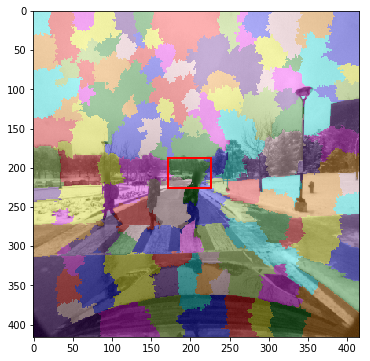

In [189]:
#boundingbox overlap with superpixels
from skimage.color import label2rgb
from skimage.measure import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#image_label_overlay = label2rgb(segments_quick, image=image_to_explain)
image_label_overlay = label2rgb(superpixels, image=image_to_explain)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image_label_overlay)

i = 0 
for region in regionprops(superpixels):
    
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    
    if i == 73: #change the number here from 0 to 415
        print(minr, minc, maxr, maxc)
        ax.add_patch(rect)

    i = i + 1
    
plt.show()

In [190]:
sorted_vboxes

{'person': [(84, 212, 115, 282),
  (142, 208, 165, 285),
  (189, 209, 216, 297),
  0],
 'fire hydrant': [(350, 223, 358, 239), 1]}

In [191]:
# function to calculating % of overlapping pixels between yolo and lime superpixels

dict_result = func_overlapping_superpixel_vs_boundingbox(sorted_vboxes, dict_superpixel_coor, 5)
print(dict_result)

j =  0 (84, 212, 115, 282)
person , upper left coor= 84 212 lower right coor =  115 282
The superpixel =  90
total pixels inside superpixels =  1353 0 0 0
The superpixel =  105
total pixels inside superpixels =  721 0 0 0
The superpixel =  73
total pixels inside superpixels =  1258 0 0 0
The superpixel =  88
total pixels inside superpixels =  844 0 0 0
The superpixel =  82
total pixels inside superpixels =  629 100 0 629
j =  1 (142, 208, 165, 285)
person , upper left coor= 142 208 lower right coor =  165 285
The superpixel =  90
total pixels inside superpixels =  1353 0 0 0
The superpixel =  105
total pixels inside superpixels =  721 0 0 0
The superpixel =  73
total pixels inside superpixels =  1258 0 0 0
The superpixel =  88
total pixels inside superpixels =  844 0 0 0
The superpixel =  82
total pixels inside superpixels =  629 0 0 0
j =  2 (189, 209, 216, 297)
person , upper left coor= 189 209 lower right coor =  216 297
The superpixel =  90
total pixels inside superpixels =  1353 1

In [192]:
import statistics 
total_labeled_obj_by_yolo = len(v_boxes)
data_stats_dict_comp_box = {}
for key in data_stats_dict.keys():
    label = key
    data_stats_dict_comp_box[key] = []
    number_of_same_type_obj = len(data_stats_dict[key])
    avg_prob_of_same_type_obj = statistics.mean(data_stats_dict[key])
    highest_prob_of_same_type_obj = max(data_stats_dict[key])
    lowest_prob_of_same_type_obj = min(data_stats_dict[key])
    percentage_this_type_among_all_type_obj = len(data_stats_dict[key])/total_labeled_obj_by_yolo
    
    #result_comp_lime_yolo_bbox = dict_result[key]
    #result_temp = list(result_comp_lime_yolo_bbox.values())
    result_temp = dict_result[key]
    total_pixel_in_superpixel_lime = result_temp[0]
    ptg_pixel_lime_in_center_yolobbox = result_temp[1] / total_pixel_in_superpixel_lime
    ptg_pixel_lime_on_border_yolobbox = result_temp[2] / total_pixel_in_superpixel_lime
    ptg_pixel_lime_inside_yolobbox = result_temp[3] / total_pixel_in_superpixel_lime
    
    data_stats_dict_comp_box[label].append(number_of_same_type_obj)
    data_stats_dict_comp_box[label].append(avg_prob_of_same_type_obj)
    data_stats_dict_comp_box[label].append(highest_prob_of_same_type_obj)
    data_stats_dict_comp_box[label].append(lowest_prob_of_same_type_obj)
    data_stats_dict_comp_box[label].append(percentage_this_type_among_all_type_obj)
    data_stats_dict_comp_box[label].append(total_pixel_in_superpixel_lime)
    data_stats_dict_comp_box[label].append(ptg_pixel_lime_in_center_yolobbox)
    data_stats_dict_comp_box[label].append(ptg_pixel_lime_on_border_yolobbox)
    data_stats_dict_comp_box[label].append(ptg_pixel_lime_inside_yolobbox)

In [193]:
#The dictionary results show the intersected pixels between superpixel and Yolo Boundingbox.
#Note that superpixel is not a rectangle shape.
#object, superpixel_ID, total_number_pixels_inside_this_superpixel, #pixels_in_centre, #pixels_boundaries, #pixels_inside_Yolobox
data_stats_dict_comp_box

{'person': [3,
  99.2797573407491,
  99.72745180130005,
  98.58593344688416,
  0.6,
  14415,
  0.014429413805064168,
  0.013596947624002775,
  0.10398890045091919],
 'fire hydrant': [1,
  60.49702167510986,
  60.49702167510986,
  60.49702167510986,
  0.2,
  3615,
  0.0,
  0.0,
  0.0]}

## The following to calculate intersections between image descriptors and boxes

In [194]:
#if we need to resize the image
#
from PIL import Image
image = Image.open('data/0000000008.png')
new_image = image.resize((416, 416))
new_image.save('data/image_416_0000000008.png')

img = cv2.imread('data/image_416_0000000008.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create() #default 500
kp, des = orb.detectAndCompute(gray_img, None) 

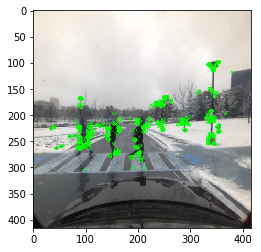

In [195]:
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2) 
plt.show()

In [196]:
#Jiye: after resizing, find more descriptors than original image
kp, des = orb.detectAndCompute(gray_img, None) 
pts = [p.pt for p in kp]
#print("key point coordinates:")
#print(pts)

pts_x = [i[0] for i in pts]
pts_y = [i[1] for i in pts]

#print("pts_x is:", pts_x)
#print("pts_y is:", pts_y)
#for kp in range(len(pts)):
#    kp_x = pts[kp][0]
#    kp_y = pts[kp][1]
#    print(kp, kp_x, kp_y)    

In [197]:
sorted_vboxes

{'person': [(84, 212, 115, 282),
  (142, 208, 165, 285),
  (189, 209, 216, 297),
  0],
 'fire hydrant': [(350, 223, 358, 239), 1]}

In [198]:
#check the number of descriptors for all the boundingbox of the same type from Yolo
def func_count_image_descriptor_bbox(lst_img_descriptor, dict_boxes, gap):
    
    pts = lst_img_descriptor
    result_dict={}
    for key in dict_boxes.keys():
        list_multiple_boxes_coor = dict_boxes[key]
        result_dict[key] = []
        
        for i in range(len(list_multiple_boxes_coor)):
            if type(list_multiple_boxes_coor[i]) != int:
                xmin = list_multiple_boxes_coor[i][0] #xmin
                xmax = list_multiple_boxes_coor[i][2] #xmax
                ymin = list_multiple_boxes_coor[i][1] #ymin
                ymax = list_multiple_boxes_coor[i][3] #ymax
        
                for kp in range(len(pts)):
                    kp_x = pts[kp][0]
                    kp_y = pts[kp][1]
            
                    #descriptors fall within the box, or close to the borders within the gap
                    condition_1 = (kp_x >= xmin) and (kp_x <= xmax) and (kp_y >= ymin) and (kp_y <= ymax)
                    condition_2 = (abs(kp_x - xmin)<=gap and abs(kp_y -ymin) <= gap) or (abs(kp_x - xmin)<= gap and abs(kp_y -ymax) <= gap) or (abs(kp_x - xmax)<=gap and abs(kp_y -ymin) <= gap) or (abs(kp_x - xmax)<= gap and abs(kp_y -ymax) <= gap)
                    if condition_1 or condition_2:
                        result_dict[key].append(((kp_x),(kp_y)))
    return result_dict

In [199]:
#Result -- % of image descriptors fall into yolo bbox
dict_comp_descriptor_yolo = func_count_image_descriptor_bbox(pts, sorted_vboxes, 5)
for key in dict_comp_descriptor_yolo.keys():
    print(key, len(dict_comp_descriptor_yolo[key])/len(pts))
print(len(pts))

person 0.458
fire hydrant 0.032
500


In [200]:
#calculating image descriptors fall into the superpixel bbox from Lime
#Since the superpixel is not in rectangle shape, it is easier to use the bbox, for now.
#superpixel bbox
dict_superpixel_bbox = func_superpixel_bbox(lime_position_list)
dict_superpixel_bbox

{0: {90: (232, 191, 279, 251),
  105: (288, 0, 314, 48),
  73: (187, 172, 226, 226),
  88: (240, 238, 271, 285),
  82: (219, 86, 265, 109)},
 1: {76: (206, 289, 251, 342),
  78: (214, 220, 236, 251),
  80: (214, 210, 251, 250),
  102: (267, 187, 309, 218),
  77: (206, 378, 237, 416)}}

In [201]:
print(lime_position_label_pair_list)
sorted_vboxes

[(0, 'person'), (1, 'fire hydrant')]


{'person': [(84, 212, 115, 282),
  (142, 208, 165, 285),
  (189, 209, 216, 297),
  0],
 'fire hydrant': [(350, 223, 358, 239), 1]}

In [202]:
lime_bbox={}

for key in dict_superpixel_bbox.keys():
 
    label = [item for item in lime_position_label_pair_list if key in item][0][1] 
    print(label)
    lime_bbox[label] = []
    value_dict = dict_superpixel_bbox[key]
    for key in value_dict.keys():
        lime_bbox[label].append(tuple((value_dict[key][1],value_dict[key][0],value_dict[key][3],value_dict[key][2])))
    #lime_bbox[label]=tuple(value_dict.keys[0], )
    
lime_bbox


person
fire hydrant


{'person': [(191, 232, 251, 279),
  (0, 288, 48, 314),
  (172, 187, 226, 226),
  (238, 240, 285, 271),
  (86, 219, 109, 265)],
 'fire hydrant': [(289, 206, 342, 251),
  (220, 214, 251, 236),
  (210, 214, 250, 251),
  (187, 267, 218, 309),
  (378, 206, 416, 237)]}

In [203]:
dict_comp_descriptor_lime = func_count_image_descriptor_bbox(pts, lime_bbox, 5)
dict_comp_descriptor_lime
for key in dict_comp_descriptor_lime.keys():
    print(key, len(dict_comp_descriptor_lime[key]))

person 158
fire hydrant 147


In [204]:
data_stats_dict_comp_box

{'person': [3,
  99.2797573407491,
  99.72745180130005,
  98.58593344688416,
  0.6,
  14415,
  0.014429413805064168,
  0.013596947624002775,
  0.10398890045091919],
 'fire hydrant': [1,
  60.49702167510986,
  60.49702167510986,
  60.49702167510986,
  0.2,
  3615,
  0.0,
  0.0,
  0.0]}

In [205]:
for key in data_stats_dict_comp_box.keys():
    label = key    
    print(key, data_stats_dict_comp_box[key])
    ptg_img_des_in_yolobbox = len(dict_comp_descriptor_yolo[key])/len(pts)
    ptg_img_des_in_lime = len(dict_comp_descriptor_lime[key])/len(pts)
    data_stats_dict_comp_box[key].append(ptg_img_des_in_yolobbox)
    data_stats_dict_comp_box[key].append(ptg_img_des_in_lime)
    

person [3, 99.2797573407491, 99.72745180130005, 98.58593344688416, 0.6, 14415, 0.014429413805064168, 0.013596947624002775, 0.10398890045091919]
fire hydrant [1, 60.49702167510986, 60.49702167510986, 60.49702167510986, 0.2, 3615, 0.0, 0.0, 0.0]


In [206]:
data_stats_dict_comp_box

{'person': [3,
  99.2797573407491,
  99.72745180130005,
  98.58593344688416,
  0.6,
  14415,
  0.014429413805064168,
  0.013596947624002775,
  0.10398890045091919,
  0.458,
  0.316],
 'fire hydrant': [1,
  60.49702167510986,
  60.49702167510986,
  60.49702167510986,
  0.2,
  3615,
  0.0,
  0.0,
  0.0,
  0.032,
  0.294]}

In [207]:
import pandas as pd
#col_name_list=['type',2,3,4,5,6,7,8,9,10,11]
col_name_list=['type','#_of_same_type_obj_YOLO','avg_prob_of_same_type_obj','highest_prob_of_same_type_obj','lowest_prob_of_same_type_obj','percent_this_type_among_all_type_obj','total_pixel_in_superpixel_lime','percent_pixel_lime_in_center_yolobbox','percent_pixel_lime_on_border_yolobbox','percent_pixel_lime_inside_yolobbox','percent_img_des_in_yolobbox','percent_img_des_in_lime']
df_stats_2019_02_27_0022_0000000027=pd.DataFrame.from_dict(data_stats_dict_comp_box, orient='index').reset_index()
df_stats_2019_02_27_0022_0000000027.columns=col_name_list



In [208]:
df_stats_2019_02_27_0022_0000000027

,type,#_of_same_type_obj_YOLO,avg_prob_of_same_type_obj,highest_prob_of_same_type_obj,lowest_prob_of_same_type_obj,percent_this_type_among_all_type_obj,total_pixel_in_superpixel_lime,percent_pixel_lime_in_center_yolobbox,percent_pixel_lime_on_border_yolobbox,percent_pixel_lime_inside_yolobbox,percent_img_des_in_yolobbox,percent_img_des_in_lime
0,person,3,99.279757,99.727452,98.585933,0.6,14415,0.014429,0.013597,0.103989,0.458,0.316
1,fire hydrant,1,60.497022,60.497022,60.497022,0.2,3615,0.000000,0.000000,0.000000,0.032,0.294


In [209]:
df_stats_2019_02_27_0022_0000000027.to_csv('df_stats_ALLBBOX_image_416_0000000008.csv', index=True)